In [60]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
%matplotlib inline


# Dimension reduction and clustering libraries
%pip install umap-learn
import umap
%pip install hdbscan
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

python(4379) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


python(4380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


Load in the test data.

In [61]:
sub1test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-001_Resp_Test.npy")
sub2test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-002_Resp_Test.npy")
sub3test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-003_Resp_Test.npy")
sub4test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-004_Resp_Test.npy")
sub5test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-005_Resp_Test.npy")
print(sub1test.shape)
print(sub2test.shape)
print(sub3test.shape)
print(sub4test.shape)
print(sub5test.shape)

(60784, 4, 600)
(53927, 4, 600)
(64700, 4, 600)
(61899, 4, 600)
(53421, 4, 600)


Concatenate all of the data.

In [62]:
# Each element should be a NumPy array of shape [n_voxels, 4, 60]
subject_list = [sub1test, sub2test, sub3test, sub4test, sub5test]

Create a genre label vector to feed into the UMAP function.

In [63]:
# Load the .mat file (adjust the path if needed)
data = sio.loadmat('/Users/jenniferarakaki/Documents/neuro120/8275363/AcrossGenre_Order_Test.mat')
test_run_data = data['across_genre_rn_test']  # shape: (6 runs, 4 reps, 10 genres)

# Step 1: Extract numeric genre IDs
genre_labels = []
for run in range(6):  # 6 runs
    for track_pos in range(10):  # 10 tracks per run
        genre_id = int(test_run_data[run, 0, track_pos])
        genre_labels.append(genre_id)  # values: 1–10

# Step 2: Repeat each genre label 4 times (for 4 reps)
genre_labels_full = np.repeat(genre_labels, 4)  # shape: (240,)

# Step 3: Repeat for 5 subjects
genre_labels_full_all = np.tile(genre_labels_full, 5)  # shape: (1200,)

# Step 4: Convert to names using the corrected mapping
genre_names = [
    'country',    # index 1
    'reggae',     # index 2
    'rock',       # index 3
    'blues',      # index 4
    'classical',  # index 5
    'hiphop',     # index 6
    'disco',      # index 7
    'jazz',       # index 8
    'metal',      # index 9
    'pop'         # index 10
]

# ✅ Create labeled vectors
genre_labels_named_240 = [genre_names[i - 1] for i in genre_labels_full]
genre_labels_named_1200 = [genre_names[i - 1] for i in genre_labels_full_all]

# ✅ Quick check
print("First 12:", genre_labels_named_240[:12])
print("First 12 of full set:", genre_labels_named_1200[:12])
print("Length 240:", len(genre_labels_named_240))
print("Length 1200:", len(genre_labels_named_1200))


First 12: ['pop', 'pop', 'pop', 'pop', 'rock', 'rock', 'rock', 'rock', 'country', 'country', 'country', 'country']
First 12 of full set: ['pop', 'pop', 'pop', 'pop', 'rock', 'rock', 'rock', 'rock', 'country', 'country', 'country', 'country']
Length 240: 240
Length 1200: 1200


Ok, so we aren't seeing significant clustering across time points so let's try a different approach. 

average voxels across a period

Here, we are reshaping the data so that it's containing the first 3 repetitions. The last one will be kept for testing.

Each repetition has 60 tracks: 10 tracks per run. We are concatentating 3 repetitions of these 60 tracks. That will total to 180 tracks total.

In [64]:
voxels = 60784
tracks = 60
timepoints_per_track = 10

sub1test_reshaped = np.transpose(sub1test[:, :3, :].reshape(voxels, 3, tracks, timepoints_per_track), [0,3,2,1]).reshape(voxels*timepoints_per_track,tracks*3)
sub1test_reshaped.shape

(607840, 180)

In [65]:
# tracks x responses @ responses x tracks = tracks x tracks
sub1test_reshaped -= sub1test_reshaped.mean(axis=0)
sub1test_reshaped /= sub1test_reshaped.std(axis=0)
tracksxtracks = sub1test_reshaped.T @ sub1test_reshaped

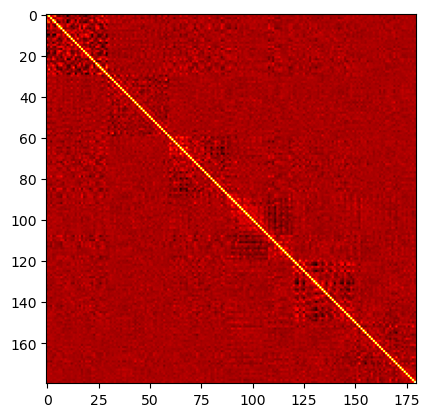

In [66]:
plt.imshow(tracksxtracks[:, :], cmap='hot')
plt.show()

This will be structured as track 1 rep 1, track 1 rep 2, track 1 rep 3, track 2 rep 1, etc. Each column is one track-repetition, and each row corresponds to a specific timepoint at a voxel

Check that it was reshaped correctly. These two should print the same thing.

In [67]:
# track 6, rep 0, voxel 101, timepoints 0-9
sub1test_reshaped[1000:1010, 15] 

array([-1.888962  , -0.23928761,  1.8228055 ,  0.5855496 ,  0.173131  ,
        0.173131  , -0.23928761,  1.4103869 , -0.23928761,  1.8228055 ],
      dtype=float32)

In [68]:
print(sub1test.shape)
print(sub1test[100, 0, 50:60])


(60784, 4, 600)
[-2.1766996  -0.4992093   1.5976536   0.33953583 -0.07983673 -0.07983673
 -0.4992093   1.1782811  -0.4992093   1.5976536 ]


In [69]:
test = np.arange(120)
test = test.reshape(2, 3, 20)
# 2 voxels, 3 repetitions, 4 * 5 track timepoints
test.shape

(2, 3, 20)

In [70]:
test_reshaped = np.transpose(test[:, :3, :].reshape(2, 3, 4, 5), [0,3,2,1]).reshape(2*5,4*3)
# voxel * timepoints_per_track, tracks * repetitions

In [71]:
print(test[1, 0, 0:5])
print(test_reshaped[5:10, 0])

# 2 voxels, 3 repetitions, 4 * 5 track timepoints
# 2nd voxel 2nd track 2nd rep
print(test[1, 1, 5:10])
print(test_reshaped[5:10, 4])

[60 61 62 63 64]
[60 61 62 63 64]
[85 86 87 88 89]
[85 86 87 88 89]


sub1test_reshaped format:

(607840, 60): voxels * 10 timepoints, 60 tracks
 
 all timesteps for first voxel, all timesteps for second voxel, stacked. then by track

 need to do that for the first three reptitions. save the last one for testing

 full shape should be (voxels * )

In [72]:
genre_labels[0:10]
genre_180 = np.repeat(genre_labels, 3)

print(genre_180)

[10 10 10  3  3  3  1  1  1  4  4  4  7  7  7  9  9  9  2  2  2  5  5  5
  6  6  6  8  8  8  9  9  9 10 10 10  5  5  5  8  8  8  3  3  3  6  6  6
  1  1  1  2  2  2  4  4  4  7  7  7  5  5  5  1  1  1 10 10 10  3  3  3
  8  8  8  4  4  4  2  2  2  7  7  7  9  9  9  6  6  6  7  7  7  3  3  3
 10 10 10  9  9  9  1  1  1  5  5  5  4  4  4  2  2  2  8  8  8  6  6  6
  8  8  8  3  3  3  2  2  2  7  7  7  4  4  4  5  5  5 10 10 10  1  1  1
  6  6  6  9  9  9  1  1  1  8  8  8  2  2  2  4  4  4  7  7  7  6  6  6
  5  5  5  3  3  3 10 10 10  9  9  9]


In [73]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Move the time dimension to be part of the features
# Result: shape (voxels * timepoints_per_track, tracks)
# X_tracks = reshaped.transpose(0, 1, 2).reshape(voxels * timepoints_per_track, tracks)

clf = LogisticRegression(random_state=0).fit(sub1test_reshaped.T, genre_180)

In [74]:
clf.predict(sub1test_reshaped[:, 0:1].T)

array([10])

In [75]:
genre_180[0]

10

Voxel 27536, Time 9: Weight 0.0020
Voxel 22449, Time 6: Weight 0.0018
Voxel 38096, Time 3: Weight -0.0018
Voxel 9256, Time 5: Weight 0.0017
Voxel 6074, Time 0: Weight -0.0017
Voxel 44649, Time 1: Weight 0.0017
Voxel 7960, Time 1: Weight -0.0017
Voxel 42115, Time 7: Weight 0.0017
Voxel 1122, Time 7: Weight 0.0017
Voxel 1302, Time 1: Weight 0.0017
Voxel 36071, Time 7: Weight 0.0017
Voxel 11148, Time 1: Weight 0.0017
Voxel 39147, Time 7: Weight -0.0017
Voxel 30966, Time 7: Weight -0.0017
Voxel 53000, Time 9: Weight 0.0017
Voxel 35293, Time 5: Weight -0.0017
Voxel 16979, Time 0: Weight -0.0017
Voxel 40619, Time 8: Weight 0.0016
Voxel 2975, Time 2: Weight 0.0016
Voxel 40775, Time 6: Weight -0.0016
Voxel 919, Time 8: Weight 0.0016
Voxel 14160, Time 3: Weight -0.0016
Voxel 48933, Time 2: Weight -0.0016
Voxel 44452, Time 9: Weight 0.0016
Voxel 34318, Time 4: Weight -0.0016
Voxel 37492, Time 6: Weight 0.0016
Voxel 44895, Time 5: Weight 0.0016
Voxel 46, Time 7: Weight 0.0016
Voxel 27518, Time 9:

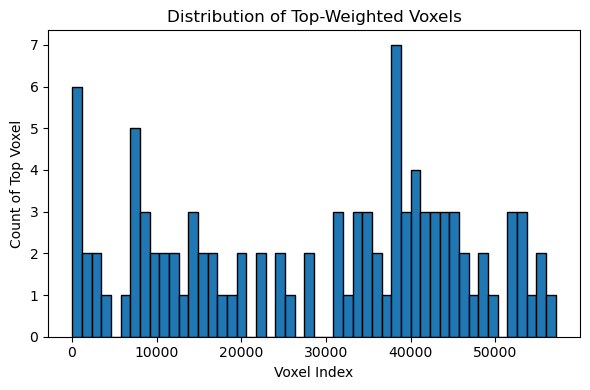

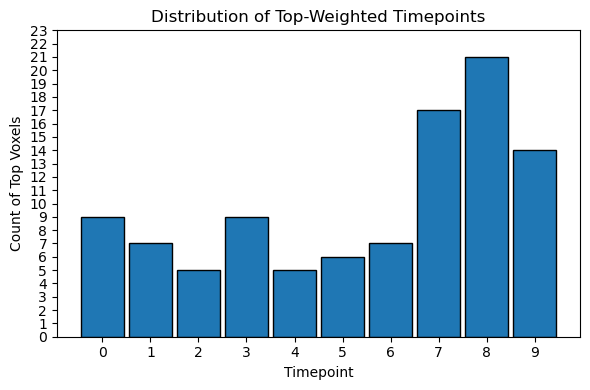

In [76]:
clf.score(sub1test_reshaped.T, genre_180)

import numpy as np

# Step 1: get weight vector
weights = clf.coef_[0]  # (n_features,) for binary classification

# Step 2: get top-N influential feature indices
top_feature_indices = np.argsort(np.abs(weights))[-100:]  # top 100 by absolute weight

# Step 3: convert flat index back to (voxel, timepoint)
n_voxels = 60784  # or however many voxels you have
timepoints = 10

for flat_idx in reversed(top_feature_indices):
    voxel_idx = flat_idx // timepoints
    time_idx = flat_idx % timepoints
    print(f"Voxel {voxel_idx}, Time {time_idx}: Weight {weights[flat_idx]:.4f}")
    
# Collect all voxel indices from your top features
voxel_indices = [flat_idx // timepoints for flat_idx in top_feature_indices]

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(voxel_indices, bins=50, edgecolor='black')  # You can change bins=50 as needed
plt.xlabel("Voxel Index")
plt.ylabel("Count of Top Voxel")
plt.title("Distribution of Top-Weighted Voxels")
plt.tight_layout()
plt.show()

# let's only include each voxel once in this list so we can use it for the umap
unique_voxel_indices = np.unique(np.array(top_feature_indices) // 10)
    
# Collect all time indices from your top features
time_indices = [flat_idx % timepoints for flat_idx in top_feature_indices]

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(time_indices, bins=np.arange(11) - 0.5, edgecolor='black', rwidth=0.9)
plt.xticks(range(10))
plt.yticks(np.arange(0, plt.gca().get_ylim()[1] + 1, 1))
plt.xlabel("Timepoint")
plt.ylabel("Count of Top Voxels")
plt.title("Distribution of Top-Weighted Timepoints")
plt.tight_layout()
plt.show()

inspect the weights to see what it's sensitive to. some weights may be high (timesteps * voxels)

maybe theres a time step or voxel where the weight is particularly high

make a new genre vector to fit the t1r1, t1r2, t1r3, t2t1, etc. Don't need to include time points, because that is already encoded in the reshaped matrix

In [77]:
# Repeat each genre 3 times (for 3 reps)
y = np.repeat(genre_labels, 3)  # length = 180
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Check shape
print("Genre vector shape:", y.shape)
assert y.shape[0] == sub1test_reshaped.T.shape[0], "Mismatch with number of columns in X"

print("Genre labels (first 10):", genre_labels[:10])  # should be per-track
print("y (first 30):", y[:30])  # should repeat each genre 3 times


Genre vector shape: (180,)
Genre labels (first 10): [10, 3, 1, 4, 7, 9, 2, 5, 6, 8]
y (first 30): [10 10 10  3  3  3  1  1  1  4  4  4  7  7  7  9  9  9  2  2  2  5  5  5
  6  6  6  8  8  8]


UMAP on learned weight voxels

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


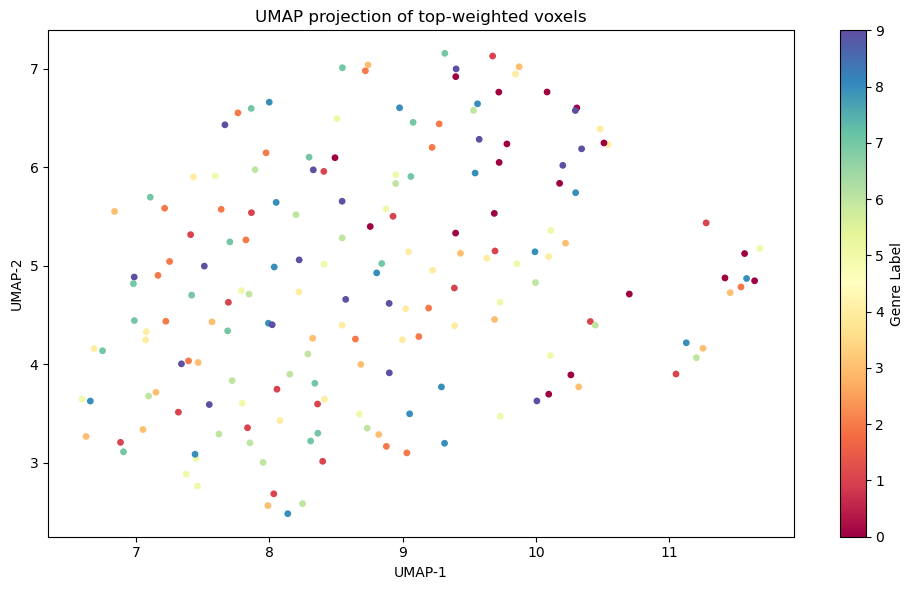

In [78]:
import numpy as np
import umap
import matplotlib.pyplot as plt



# Subset the original voxel data using top-weighted voxels ---
n_voxels = 60784
n_timepoints = 10
samples = 180

# Your input matrix
# sub1test_reshaped: shape (607840, 180)

# Compute row indices for timepoints 6–9 of each selected voxel
timepoints_to_avg = np.array([6, 7, 8, 9])
row_indices = unique_voxel_indices[:, None] * n_timepoints + timepoints_to_avg  # shape: (n_voxels_kept, 4)

# Extract and average those rows across the timepoint axis
voxel_avg_values = sub1test_reshaped[row_indices, :].mean(axis=1)  # shape: (n_voxels_kept, 180)

# Transpose to shape (samples, voxels)
X_avg = voxel_avg_values.T  # shape: (180, n_voxels_kept)

# --- Step 6: UMAP on PCA output ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X_avg)

# Step 5: Visualize ---
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y_encoded, cmap='Spectral', s=15)
plt.colorbar(scatter, label='Genre Label')
plt.title("UMAP projection of top-weighted voxels")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()
